# Titanic data
### This is my first project to get familier with kaggle. 
<br>
Sinking of titanic was one of the most infamous and tragic events in history. The goal of this project is to predict wheather a passenger will survive this incident based on the details provided in the dataset.

In [1]:
#load data
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

data_dir = 'data/'

data = pd.read_csv(data_dir + 'train.csv')
testdata = pd.read_csv(data_dir + 'test.csv')

d1 = data.copy()
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
print(f'train shape: {data.shape}')
print(f'test shape: {testdata.shape}')
print(data.columns)

train shape: (891, 12)
test shape: (418, 11)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


So the dataset consists of 891 rows and 12 columns. That means I have details about 891 passengers about the above mentioned features.
<br><br>
The variables **PassengerId**, **Survived**, **Name**, **Sex**, **Age**, **Ticket**, **Fare** are self explanatory.
<br><br>
**Pclass** : Ticket class, this explains quality of living <br>
**SibSp** : Number of sibling or spouse aboard <br>
**Parch** : Number of parents or children aboard <br>
**Embark** : Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

Now, we need to check wheather there are nan values in the dataset. i.e. If some parts of the data are missing or not. 

In [3]:
# check which columns contain nan values
from functon_scripts.find_nan_cols import find_nan_cols

find_nan_cols(data)
find_nan_cols(testdata)

{'Age': 177, 'Cabin': 687, 'Embarked': 2}
{'Age': 86, 'Fare': 1, 'Cabin': 327}


* Out of 891 rows in training set we have 687 nan values in `Cabin`. And out of 418 rows in test set we have 327 missing values. I think only 104 rows in 891 rows will not give sufficient information to infer about anything.
* The number of missing values in `Age` is also large. But Age could be a very useful variable to predict survival capability of any person.
* Only 2 missing values in `Embarked` in the training set, when there is no missing value of the same in the test set.
* We have a new feature with missing values in the test set, although there is only one missing value. To generalize our model, we also need to figure out a way to impute `Fare` also 

In [4]:
# Impute Cabin nan values with Z, and extract the first letter from each cabin number
from functon_scripts.CustomEstimators import CabinImputer
data.Cabin = CabinImputer(imp="Z").fit_transform(data[['Cabin']].to_numpy())

People living together can be figured out by extracting their cabin number as well as ticket number. The type of Cabin (eg. C, D, G, etc.) can give some hint about the location of the cabin which in turn may hint about survival of the families. Firstly, we want to see if at all the Cabin feature hints anything about survival of the passengers.

In [5]:
pd.crosstab(data.Survived, data.Cabin, rownames=['labels'], colnames=['Cabin'])

Cabin,A,B,C,D,E,F,G,T,Z
labels,,,,,,,,,
0,8,12,24,8,8,5,2,1,481
1,7,35,35,25,24,8,2,0,206


Here we can see that people living in cabin B, D, E has very high probability of surviving. But, this numbers can be misleading since we do not know the Cabin numbers of most of the people.

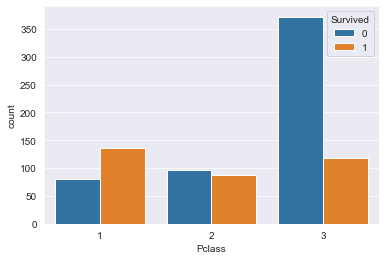

In [6]:
_ = sns.countplot(data=data, x='Pclass', hue='Survived')

So people in class 1 has higher chance of surviving whereas people in class 3 are less probable to survive.

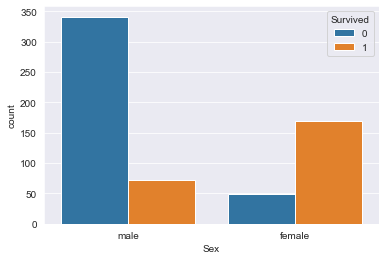

In [7]:
_ = sns.countplot(data=data[data.Age > 15], x='Sex', hue='Survived')

Well that's not really surprising is it? :D.<br>
### It turns out that the real challenge lies in detecting a male surviver and a female casualty.

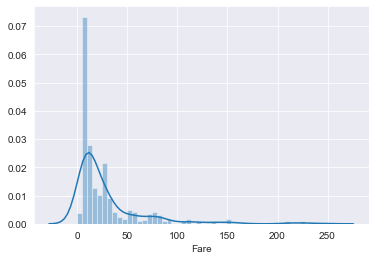

In [8]:
_ = sns.distplot(data.Fare[data.Fare<250], kde=True)

So you can see most of the Fares lie on the interval (0, 50) more specifically (5, 15). The cost of the fare may decide the ablity of surviving. To visualize this assumption, we shall discretize the values of Fare by putting each of the values in some carefully created classes say {(-1, 5), (5, 10), (10, 35), (35, 100), (100, 250), (250, inf)}. Each class will represent the financial background of the corresponding passenger. The bins/classes need to be created in such a way, inference about survival becomes most precise. Notice that I put a -1 as the class boundary of the first class, because there are a few people who have boarded the ship free of cost! Hence I created a class of people with really low fare.


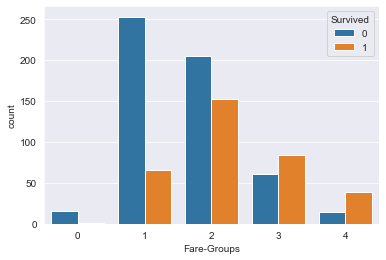

In [9]:
from functon_scripts.SpecialImputers import DiscreteVar

farebins = [-1, 5, 10, 35, 100, np.inf]
data['Fare-Groups'] = DiscreteVar(bins=farebins).fit_transform(d1[['Fare']])
_ = sns.countplot(x='Fare-Groups', hue='Survived', data=data)

Evidently, the richer a person is, more is the probablity of him surviving the disaster. The counts shown in the above plot will depend on the class boundaries. I think my current choice is quite decent.

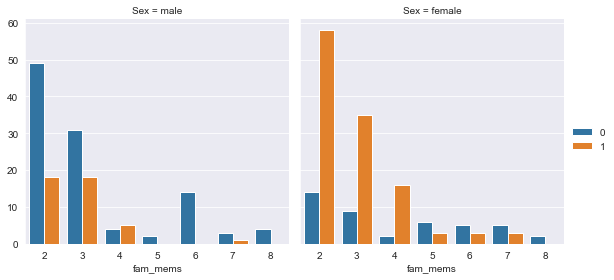

In [10]:
data['fam_mems'] = data.SibSp + data.Parch + 1 #considering the person himself/herself

_ = sns.FacetGrid(data=data[data.fam_mems > 1], col='Sex', size=4)
_ = _.map_dataframe(sns.countplot,'fam_mems', hue='Survived', palette=sns.color_palette()).add_legend()

It is again quite clear that men inside a family had to sacrifice their life in order to save the women in the family. When the family size is larger than 3, number of children and aged people will also increase. It is not clear which age group was more likely to be saved than other.

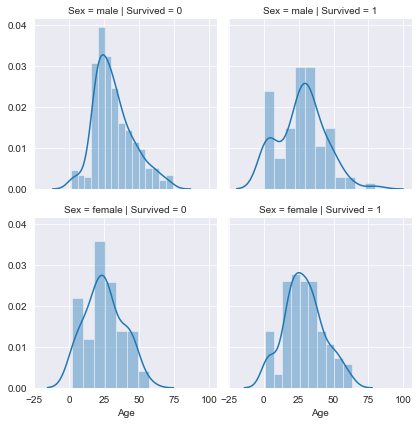

In [11]:
_ = sns.FacetGrid(data=data, col='Survived', row='Sex', size=3)
_ = _.map(sns.distplot, 'Age')

Here we see that children were prioritized to be saved irrespective of the gender. ALthough if we only consider the females, survival chance seems to be almost equal. But the number of survivors are still higher relative to other `Age-Groups`. People in the age group of (20, 30) also has higher probability of surviving. So creating several `Age-Groups` as we did with `Fare`, will make the problem easy to visualize and also training models can be done faster. Also note there are already high numbers of missing values in the 'Age' values, grouping those variables would make the imputation easier. More on imputing `Age` is covered later. 

I dont think the `Ticket` and `Name` variable provide any information about who is going to survive and who is not. But clusterings can be discovered by using ticket numbers and family name, which will show groups of people who have boarded the ship together. Which is a useful information to have. Hence they can help to impute `Cabin`, `Fare` and `Age`. Again `Cabin` contains a lot of missing values, so we can not use it to determine the surviving probability of a person.
<br> <br>
With `Name`, `Ticket` and `Cabin` being out of the picture, it is not possible to locate a "danger zone" in the ship anymore. For example, one part of the ship could have drowned before other parts, and may be the people on that part were not prepared for such a disaster and could not save themselves. But there is now no way to find that out, wheather this was true or not. 
<br><br>
I feel that the sampling procedure used to separate the training and test dataset is not quite right. For example I have tried to find out clusterings in the passengers using various unsupervised algorithms like DBSCAN and KNN. And I have found there are many passengers who have family members but his/her family members are not included in the training set. Finding out the groups could help a model predict the surviving capability of that group as a whole. But there is no chance of that because of poor sampling.

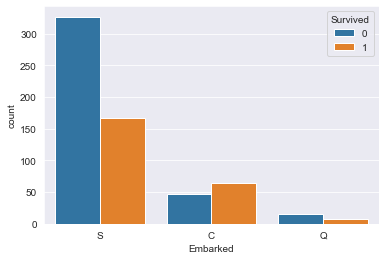

In [12]:
_ = sns.countplot(data=data[data.Age > 15], x='Embarked', hue='Survived')

Hmm, people from Cherbourg seem to have more probability of surviving. Intuitively embarkation should not imply anything about surviving capability of a person. But may be people from Cherbourg are richer or better at survivng disasters who knows?

### Data cleaning stage 1:
* We shall impute `Embarked` by the most frequent element in it, which is 'S'. Although the imputation could be done better by finding out family members or friends through `Ticket` and `Cabin` but I'll like to avoid this kind of complexity here.
* Then we will have to one hot encode `Sex` and `Embarked`
* `Fare` and `Age` should then be categorized into several groups
* And finally drop unused columns like `PassengerId`, `Name`, `Ticket` and `Cabin`

In [13]:
from sklearn.compose import ColumnTransformer
from functon_scripts.CustomEstimators import DropColumns, EmbarkedImputer
from functon_scripts.SpecialImputers import DiscreteVar
from sklearn.preprocessing import OneHotEncoder

labels = d1.Survived
data = d1.copy()
data = data.drop('Survived', axis=1)

cols = data.columns.drop(['Embarked', 'Age', 'Sex', 'Fare'])
fare_bins = [-1, 5, 10, 35, 100, np.inf]
age_bins = [0, 18, 32, np.inf] # more on this later
clean_1 = ColumnTransformer([
    ('drp', DropColumns(drop_ix=[0, 2, 5, 6]), cols),
    ('ohe', OneHotEncoder(), ['Sex']),
    ('dAge', DiscreteVar(bins=age_bins), ['Age']),
    ('dFare', DiscreteVar(bins=fare_bins), ['Fare']),
    ('EmbImp', EmbarkedImputer(), ['Embarked'])
])

In [14]:
clean_data = clean_1.fit_transform(data)
clean_testdata = clean_1.fit_transform(testdata)

## Imputation of missing values:

### Fare imputation:
We shall start by imputing Fare. Although there are no missing values in `Fare` in the training data set, but there is one missing value in the test dataset. We shall fit a model, using other available datasets to impute `Fare`. 
* Building a model to impute only one unit may not be a logical decision, but I'm here trying to generalise my model so that it can fit with any possible dataset with missing values in `Age`, `Fare` and `Embarked`. <br>
* Using other variables to impute one would run into issues of multicollinearity. So models those use logistic regression will face all sorts of multicollinearity problems, and one have to pay great attention to regularize those parameters. But I strongly feel this kind of problem is best addressed by decision trees, and decision trees will actually improve if we make the signals more clear to the classifier.<br>

The class of living, the number of members of the family, port of embarakation can tell a lot about how much wealthy a person or a family is. So we shall use all of those variables to impute `Fare`. We have used extreme gradient boosted decision trees and fine tuned it's hyper-parameters. After fitting the model, let's see how does it perform with the data it has not seen before. We shall replace the `Fare` values with NaN in the test data set and check the model's performance.

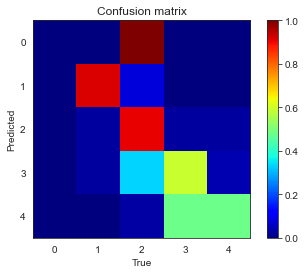

In [15]:
from functon_scripts.SpecialImputers import ImputeFare
from functon_scripts.modified_confusion_matrix import modified_confusion_matrix
from functon_scripts.SpecialImputers import Fare_ix

fimp = ImputeFare().fit(clean_data)

clean_testdata_ = clean_testdata[~testdata.Fare.isnull()]
y = clean_testdata_[Fare_ix].astype(float)
clean_testdata_[Fare_ix] = np.array([np.nan]*clean_testdata_.shape[0])

y_hat = fimp.transform(clean_testdata_)[Fare_ix]
modified_confusion_matrix(y, y_hat.astype(float))

That's not too bad. Fare group-1 and group-2 is predicted with high accuracy. Some times group-3 and group-1 is miss classified as group-2. Classification error is a little high for group-3 and group-4 but that's the best we can get using the available variables. It can predict a wealthy person with probability more than 0.5! Which is pretty satisfactory result for small number of imputations. Let's see which variable were important to predict `Fare`.

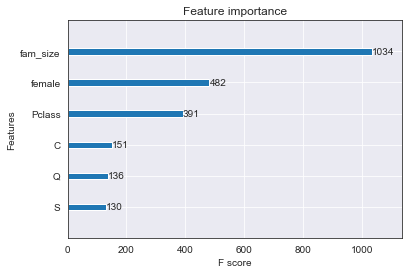

In [16]:
from xgboost import plot_importance
fimp.model.get_booster().feature_names = ['Pclass', 'female', 'male', 'C', 'Q', 'S', 'fam_size']
plot_importance(fimp.model.get_booster())

### Age imputation:
Now we want to impute `Age` in a way similar to how we imputed `Fare`. 
* Intuitively `Sex`, `Parch` and `SibSb` are the main variables that can tell us about a person's age. Although predicting `Age` accurately from this variables is not possible at all. It could be more helpful if `Parch` was split inro 'Parents' and 'Children'. May be by tracking down the family members using `Ticket`, `Name` and `Cabin` we could generate this variables which I have avoided for some reason already mentioned. 
* This time we can also use `Fare` to impute `Age`.
* Based on the data we have the best model can only differentiate between "too young", "middle age" and "very old" persons. But remember our main goal is to use age to predict surviving capability of a passenger. Classifying people into different age-groups always loses some information of the `Age`. The classification should be done carefully so that implication about pulling through the disaster becomes easier. 
* I have made several sets of classes and tested the best model based on those classes. Finally, I decided to have three Age-Groups viz. {$(0, 18), (19, 32), (33, \infty)$}. The reason I have chosen this boundaries will be clear from the next plot.

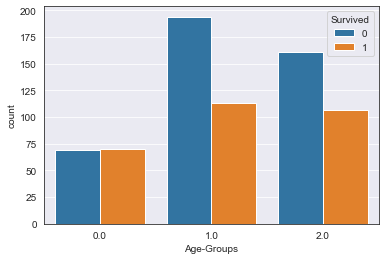

In [17]:
from functon_scripts.SpecialImputers import DiscreteVar

data = d1.copy()
agebins = [-1, 18, 32, np.inf]
data['Age-Groups'] = DiscreteVar(bins=agebins).fit_transform(data[['Age']])
_ = sns.countplot(x='Age-Groups', hue='Survived', data=data)

The class 1 has more or less 50% chance of surviving. The more we can properly classify a person whose age is not available, the better our prediction will be. <br>
I really do not feel good to lose information on this scale and finally coming up with only 3 groups. But only other option I have is to train separate models depending upon wheather age is available, and finally combine them together to make a prediction. The models will learn different parameters and will be very different from one another. Which will fail to generalise the problem

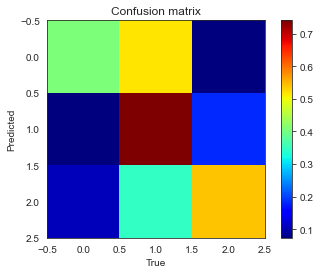

In [18]:
from functon_scripts.SpecialImputers import ImputeAge
from functon_scripts.modified_confusion_matrix import modified_confusion_matrix
from functon_scripts.SpecialImputers import Age_ix

agimp = ImputeAge().fit(clean_data)

clean_testdata_ = clean_testdata[~testdata.Age.isnull()]
y = clean_testdata_[Age_ix].astype(float)
clean_testdata_[Age_ix] = np.array([np.nan]*clean_testdata_.shape[0])

y_hat = agimp.transform(clean_testdata_)[Age_ix]
modified_confusion_matrix(y, y_hat.astype(float))

Not too bad, some portion of age-group (0, 18) is getting misclassified as age-group (19, 32) and some part of age-group(32, $\infty$) is getting misclassified as age-group (19, 32). The number of passengers in the second group is so high that even the best model is getting slightly biased. But overall the result is pretty good.
<br><br>
Now, we have completed cleaning the data and imputing missing values. Now it's time to actually work with the main problem.

In [19]:
from sklearn.pipeline import Pipeline

clean_and_impute = Pipeline([
    ('clean', clean_1),
    ('fimp', ImputeFare()),
    ('agimp', ImputeAge())
])

## Training models and scoring modification:
* Next we want to create a validation set using stratified sampling, so that the proportion of males, females and survivors of each gender in the validation set remains the same as the whole training set. We have already seen that, gender is a very trivial explanatory variable for this problem. So we want to keep the gender ratio, and gender based survivor ratio same in the validation set and in the training set. <br><br>
* For validating wheather a model is performing well, I shall use a modified scoring for this problem. I have already mentioned that the main challenge is to detect a male survivor and a female casualty, so I'm going to penalise the model more when it wrongly classifies such cases. As proportion of males and females in the validation set remaining same as the population has been ensured, the scoring for a particular small validation set will be meaningful for the whole population. 

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

labels = d1.Survived
data = d1.drop('Survived', axis=1)

gender_survivor_group = pd.Series(3 * clean_data[:, 3] + clean_data[:, 4] + labels)

stt = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=91)
train_ix, val_ix = next(stt.split(data, labels, groups=gender_survivor_group))
train, train_label = data.iloc[train_ix], labels.iloc[train_ix]
val, val_label = data.iloc[val_ix], labels.iloc[val_ix]

I shall use a weighted f1 score. The samples with male survivors and female casualties will get weights of 0.3. And rest will get weight 0.2. 

In [21]:
from sklearn.metrics import f1_score
from functon_scripts.weighted_scorer import WeightedScorer

def weight_rule(X, y):
    gender_survivor_group = pd.Series(3 * X[female_ix] + X[male_ix] + y)
    weights = [0.2 if x in (1, 4) else 0.3 for x in gender_survivor_group]
    return np.array(weights)

weighted_f1 = WeightedScorer(f1_score, rule=weight_rule, sign=1, kwargs={})

I will train different classifiers such as SVM classifier, XGB classifier, KNN classifier and will use a hard voting method for the final prediction.

I have hypertuned each of this models to get the best parameter combinations.

In [22]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

xgb = XGBClassifier(n_estimators=53, eta=0.15, reg_lambda=0.5)
svm = svm = SVC(C=5.4, probability=True)
knn = KNeighborsClassifier(n_neighbors=9, weights='uniform')

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb), ('svm', svm), ('knn', knn)],
    voting='soft'
    )

clean_train = clean_and_impute.fit_transform(train)
clf = voting_clf.fit(clean_train, train_label)

We have used a soft voting that uses the probability of survival predicted by different classifiers. Now let us check the performance of the model with the data it has not seen before.

In [23]:
from sklearn.metrics import accuracy_score

clean_val = clean_and_impute.fit_transform(val).astype(int)
val_predict_vote = clf.predict(clean_val)

accuracy_score(val_predict_vote, val_label)

0.8444444444444444

So here we can achieve 0.85 accuracey score approximately. Let's see the variable importance for predicting wheather a passenger will survive using the xgboost model.

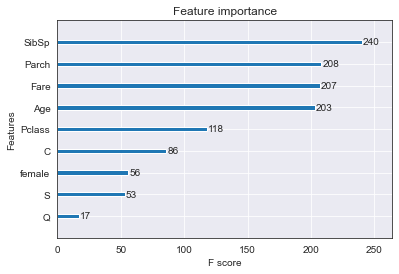

In [31]:
boosted_trees = clf.named_estimators_['xgb'].get_booster()
boosted_trees.feature_names = [
    'Pclass', 'SibSp', 'Parch', 'female', 'male', 'Age', 'Fare', 'C', 'Q', 'S'
]
plot_importance(boosted_trees)

* Notice how the final model does not rely on `female`s to predict a survivor. If I had used the `Sex` variable alone to predict survivors, and labeled each female passenger as survivors, I could get 75% accuracy. Which is obviously a very crude way to predict. Instead the final model here considers `SibSp`, `Parch`, `Fare` and `Age` to be more important than `Sex`. And still attains a 85% accuracy on the validation set. This is a great result to witness!
* Family members seem to have great impact on ultimate fate of a passenger. Which further denotes that having the information about groups of people could have improved the model even more.
* Even after having more than 150 rows of missing data in `Age`, and losing quite a lot of information in the imputation process, it still turns to be in the top 4 important features in the dataset.
<br><br> 
The final step is to create a full pipeline that will take a input data and predict the survival probability of passengers. We shall also train the model on the full dataset before predicting on the test dataset.

In [24]:
survival_prediction = Pipeline([
    ('cleaning', clean_and_impute),
    ('classify', voting_clf)
])

At this point I would like to check the stability of the model. i.e. How does the quality of prediction of this model varies for different datasets. I shall use bootstrap technic to see the average accuracy and standard deviation of the accuracy of the model.

In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(survival_prediction, data, labels, cv=10)
print(f'Average accuracy on 10 fold cross validation is {scores.mean():.2f} with error +/- {scores.std():.2f}')

Average accuracy on 10 fold cross validation is 0.82 with error +/- 0.04


I am quite happy with the outcome. Now final step is to prepare the submission file for kaggle.

In [26]:
model = survival_prediction.fit(data, labels)
predictions = model.predict(testdata)

final_data = pd.DataFrame()
final_data['PassengerId'] = testdata.PassengerId
final_data['Survived'] = predictions

final_data.to_csv('data/sub21-04-2020.csv', index=False)